## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## 使用l1

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updati

50000/50000 [==============================] - 3s 59us/step - loss: 1.6186 - acc: 0.5209 - val_loss: 1.6752 - val_acc: 0.5027
Epoch 49/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.6167 - acc: 0.5231 - val_loss: 1.7153 - val_acc: 0.4871
Epoch 50/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.6129 - acc: 0.5242 - val_loss: 1.6651 - val_acc: 0.5030
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (Non

50000/50000 [==============================] - 3s 58us/step - loss: 1.0196 - acc: 0.6922 - val_loss: 1.5165 - val_acc: 0.5350
Epoch 50/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.0091 - acc: 0.6953 - val_loss: 1.5407 - val_acc: 0.5298
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)

50000/50000 [==============================] - 3s 58us/step - loss: 0.8675 - acc: 0.6968 - val_loss: 1.3784 - val_acc: 0.5354
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
___________________________________

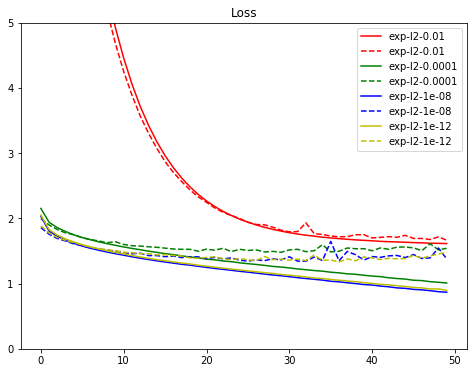

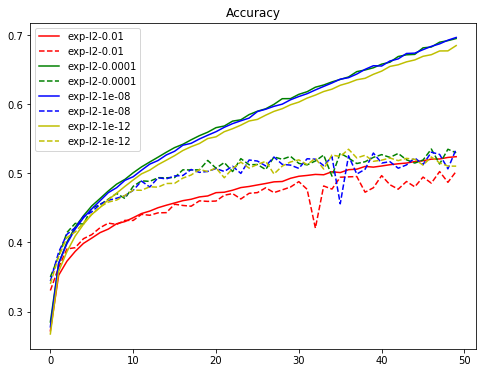

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 使用l1_l2

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 71us/step - loss: 18.7852 - acc: 0.2765 - val_loss: 17.3496 - val_acc: 0.3364
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 16.1340 - acc: 0.3554 - val_loss: 14.9782 - val_acc: 0.3690
Epoch 3/50
50000/50000 [==============================] - 3s 66us/step - loss: 13.9504 - acc: 0.3784 - val_loss: 12.9639 - val_acc: 0.3858
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 12.1024 - acc: 0.3931 - val_loss: 11.2718 - val_acc: 0.3943
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 10.5326 - acc: 0.4027 - val_loss: 9.8243 - val_acc: 0.4049
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 9.1961 - acc: 0.4093 - val_loss: 8.6013 - val_acc: 0.4066
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 8.0592 - acc: 0.4139 - val_loss: 7.5511 

50000/50000 [==============================] - 3s 60us/step - loss: 13.0106 - acc: 0.3602 - val_loss: 12.1174 - val_acc: 0.3747
Epoch 3/50
50000/50000 [==============================] - 3s 56us/step - loss: 11.3419 - acc: 0.3804 - val_loss: 10.5904 - val_acc: 0.3880
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 9.9309 - acc: 0.3954 - val_loss: 9.3013 - val_acc: 0.3875
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 8.7321 - acc: 0.4028 - val_loss: 8.1914 - val_acc: 0.4070
Epoch 6/50
50000/50000 [==============================] - 3s 55us/step - loss: 7.7104 - acc: 0.4129 - val_loss: 7.2503 - val_acc: 0.4200
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 6.8394 - acc: 0.4208 - val_loss: 6.4446 - val_acc: 0.4203
Epoch 8/50
50000/50000 [==============================] - 3s 54us/step - loss: 6.0936 - acc: 0.4268 - val_loss: 5.7654 - val_acc: 0.4280
Epoch 9/50
50000/50000 [========================

50000/50000 [==============================] - 3s 55us/step - loss: 11.3436 - acc: 0.3790 - val_loss: 10.5944 - val_acc: 0.3871
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 9.9324 - acc: 0.3920 - val_loss: 9.2945 - val_acc: 0.3969
Epoch 5/50
50000/50000 [==============================] - 3s 54us/step - loss: 8.7333 - acc: 0.4025 - val_loss: 8.1916 - val_acc: 0.4074
Epoch 6/50
50000/50000 [==============================] - 3s 54us/step - loss: 7.7109 - acc: 0.4100 - val_loss: 7.2504 - val_acc: 0.4151
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 6.8392 - acc: 0.4159 - val_loss: 6.4500 - val_acc: 0.4205
Epoch 8/50
50000/50000 [==============================] - 3s 55us/step - loss: 6.0953 - acc: 0.4223 - val_loss: 5.7616 - val_acc: 0.4252
Epoch 9/50
50000/50000 [==============================] - 3s 55us/step - loss: 5.4605 - acc: 0.4289 - val_loss: 5.1722 - val_acc: 0.4333
Epoch 10/50
50000/50000 [=========================

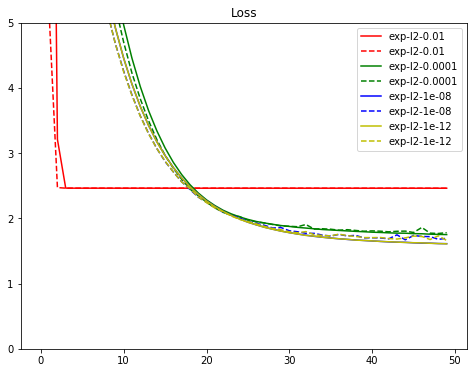

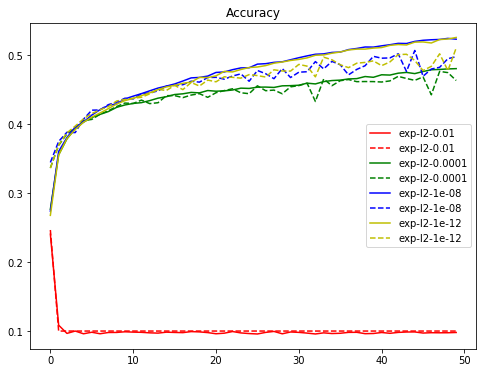

In [12]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果